<a href="https://colab.research.google.com/github/JuanPabloJP/Big-Data-2/blob/main/Topic%20Modeling/Project/Modelado_de_T%C3%B3picos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = 6>
<font color = '#3d63ba'>
<center> Datos Masivos II </center>

<font size = 10>
<font color = '#3d63ba'>
<center> Modelado de Tópicos <center>

**Equipo:**
- Joel Ávalos
- Alan Barriga 
- Pablo Hernández

El **Modelado de Tópicos** es un conjunto de herramientas matemáticas que
permiten extraer información y categorizar grandes conjuntos de
documentos. El modelado de tópicos tiene como objetivo hallar a través de
algoritmos estadísticos, los principales temas o tópicos de colecciones de
documentos.

Un tópico en el contexto de modelado de tópicos es una distribución de probabilidades de palabras para un conjunto, e indica la probabilidad que una palabra aparezca en un documento sobre un tópico en particular.

Es así que en este trabajo tenemos por objetivo separar los datos correspondientes a reseñas de amazon en una cantidad óptima de tópicos, tomando en consideración que estas reseñas están distribuidas en 9 categorías de producto diferentes para 65 productos diferentes.

## Los datos:
Este conjunto de datos es una lista de más de 28,000 reseñas de consumidores para productos de Amazon como Kindle, Fire TV Stick y más de la base de datos de productos de Datafiniti actualizada entre febrero de 2019 y abril de 2019. Cada lista de productos incluye el nombre Amazon en el campo de marca y fabricante. Todos los campos dentro de este conjunto de datos se han simplificado, y algunos se han omitido, para agilizar su análisis de datos. Esta versión es una muestra de un gran conjunto de datos. El conjunto de datos completo está disponible a través de Datafiniti.

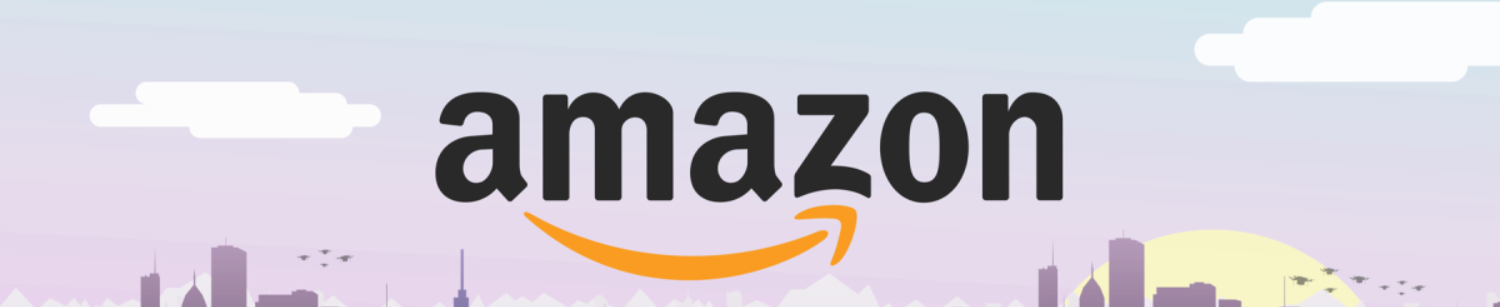

In [3]:
# La instalación de una de estas librerías invalida la instalación de la otra :c 
!pip install pyldavis
!pip install texthero


     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
ERROR: Operation cancelled by user
  Getting requirements to build wheel ... Collecting texthero
     |████████████████████████████████| 1.5 MB 5.6 MB/s 
     |████████████████████████████████| 235 kB 64.1 MB/s 
     |████████████████████████████████| 749 kB 44.9 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(option

Iniciamos importando un conjunto de librrías útiles para este trabajo:

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

Leemos el dataset sobre el cuál se va a trabajar. Del dataset original seleccionamos un conjunto de posibles comlumnas úiles de entre la cuales resaltan `reviews.text` con las reseñas, `primaryCategories` con las categorías y por ende tópicos preliminares y `id` con los identificadores únicos para los productos.

In [5]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
amz = df[['id', 'categories', 'primaryCategories', 'reviews.rating', 'reviews.text', 'reviews.title']]
amz.head()

,id,categories,primaryCategories,reviews.rating,reviews.text,reviews.title
0,AVpgNzjwLJeJML43Kpxn,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...
1,AVpgNzjwLJeJML43Kpxn,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...
2,AVpgNzjwLJeJML43Kpxn,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...
3,AVpgNzjwLJeJML43Kpxn,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...
4,AVpgNzjwLJeJML43Kpxn,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...


Observamos como se distribuyen los productos en las 9 categorías distintas. Notamos 2 (`Electronics` y `Health & Beauty`) con la mayor concentración de reseñas.

In [6]:
amz['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

Notamos que se tienen reviews para 65 productos diferentes.

In [7]:
len(amz['id'].unique())

65

El número de reviews es 28,332

In [8]:
amz.shape

(28332, 6)

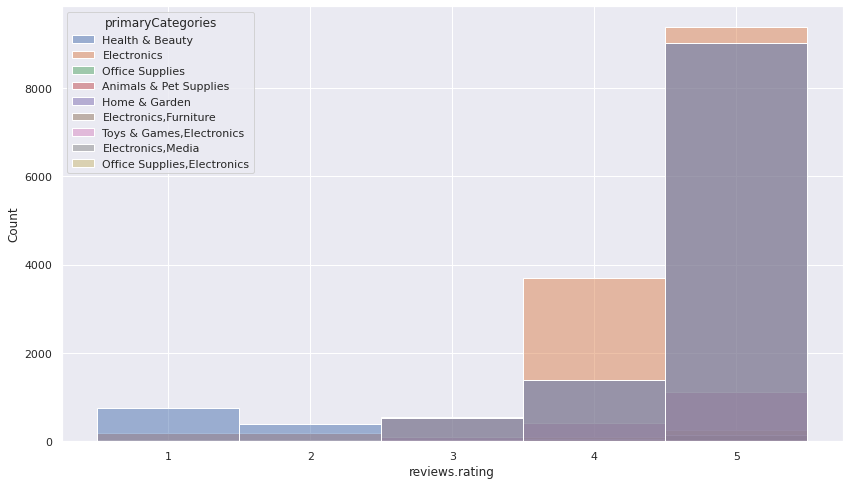

In [9]:
plt.figure(figsize=(14,8))
sns.histplot(data=amz, x="reviews.rating", hue="primaryCategories", discrete=True)
plt.show()

## Limpieza de la reviews

Para poder hacer el modelado de tópicos es importante limpiar las reviews a un formato uniforme en minúsculas, quitando las *stop words* y "lematizado".

In [10]:
import string
import nltk
nltk.download('stopwords')
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))

  return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Empezamos el proceso de limpieza definiendo algunas funciones útiles para limpiar el texto. Resaltamos la función para remover posibles emojis de los textos elaborada por el usuario **Slowkow** y publicada en su [repositorio de Github](https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)

In [11]:
import re

def low_case(x):
    return x.lower()

def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

Aplicamos estas funciones a la columna de reviews.

In [12]:
amz['reviews.text'] = amz['reviews.text'].apply(lambda z: remove_punctuations(z))
amz['reviews.text'] = amz['reviews.text'].apply(lambda z: remove_url(z))
amz['reviews.text'] = amz['reviews.text'].apply(lambda z: remove_emoji(z))

amz['reviews.text'] = amz['reviews.text'].apply(low_case)

Ahora procedemos a quitar las palabras vacías y en el proceso tokenizamos cada entrada de reviews.

In [13]:
palabras_vacias = nltk.corpus.stopwords.words('english')

def quita_palabras_vacias(texto):
  texto = texto.split()
  texto_limpio = [palabra for palabra in texto if palabra not in palabras_vacias ]
  
  return texto_limpio

In [14]:
amz['reviews.text'] = amz['reviews.text'].apply(lambda z: quita_palabras_vacias(z))

Observamos como se ve una review después de este proceso y sin lematizar.

In [15]:
amz['reviews.text'][0]

['order',
 '3',
 'one',
 'item',
 'bad',
 'quality',
 'missing',
 'backup',
 'spring',
 'put',
 'pcs',
 'aluminum',
 'make',
 'battery',
 'work']

Aplicamos la función lematizadora `doc_a_token` a cada palabra contenida en cada review.

In [16]:
stem = []
for line in amz['reviews.text']:
  consultas = []
  for c in line:
    tokens = doc_a_tokens(c)
    consultas.append(' '.join(tokens))
  stem.append(consultas)


Observamos como cambia la entrada anterior después de lematizarla.

In [17]:
stem[0]

['order',
 '3',
 'one',
 'item',
 'bad',
 'quality',
 'miss',
 'backup',
 'spring',
 'put',
 'pc',
 'aluminum',
 'make',
 'battery',
 'work']

In [18]:
detokenized_doc = []
for i in range(len(stem)):
    t = ' '.join(stem[i])
    detokenized_doc.append(t)

In [19]:
amz['reviews.text'] = detokenized_doc

Los datos de texto requieren una última preparación especial antes de que pueda comenzar a usarlos para el modelado predictivo. Las palabras deben codificarse como números enteros o valores de punto flotante para usar como entrada a un algoritmo de aprendizaje automático, llamado extracción de características (o vectorización).

El **Tfid** convertirá en token los documentos, aprenderá el vocabulario y las ponderaciones de frecuencia de los documentos inversos, y le permitirá codificar nuevos documentos.
Este es un acrónimo que significa " Frecuencia de términos - Documento inverso "Frecuencia, que son los componentes de las puntuaciones resultantes asignadas a cada palabra.

**Frecuencia de términos :** resume la frecuencia con la que aparece una palabra determinada en un documento.

**Frecuencia inversa del documento :** esto reduce la escala de las palabras que aparecen mucho en los documentos.

Sin entrar en matemáticas, TF-IDF son puntuaciones de frecuencia de palabras que intentan resaltar las palabras que son más interesantes, por ejemplo, frecuentes en un documento pero no entre documentos.
 Alternativamente, si ya tiene un CountVectorizer aprendido, puede usarlo con un TfidfTransformer para simplemente calcular las frecuencias inversas del documento y comenzar a codificar documentos.

In [20]:
#Creamos una matriz de documentos y términos usando TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
                            max_features= 1000, # máximo número de términos
                            max_df = 0.5, 
                            smooth_idf=True)

X = vectorizer.fit_transform(amz['reviews.text'])
print("Tamaño de la matriz T-D: ", X.shape) # visualizamos el tamaño de la matriz
print(X)

Tamaño de la matriz T-D:  (28332, 1000)
  (0, 981)	0.19185820604764486
  (0, 94)	0.16196643984536815
  (0, 537)	0.2757422395588869
  (0, 84)	0.5049393841407165
  (0, 558)	0.4433241313037222
  (0, 707)	0.270294427364083
  (0, 85)	0.3538556206959738
  (0, 469)	0.32410223948457345
  (0, 610)	0.3257427082918566
  (1, 506)	0.3246280987068276
  (1, 689)	0.33663523395006695
  (1, 961)	0.4553280779129521
  (1, 313)	0.4825764018706298
  (1, 133)	0.5840288302944188
  (2, 405)	0.6299137157118877
  (2, 680)	0.3744991078582189
  (2, 273)	0.6804110000370668
  (3, 117)	0.6181858085602913
  (3, 680)	0.45811133994709097
  (3, 981)	0.48807052455221195
  (3, 94)	0.4120284812605413
  (4, 393)	0.405357368372351
  (4, 521)	0.6306071202502274
  (4, 680)	0.49208009464476865
  (4, 94)	0.4425802122218672
  :	:
  (28330, 955)	0.40472775839161124
  (28330, 776)	0.21928802462558974
  (28331, 486)	0.2720108259848187
  (28331, 128)	0.2375852320241932
  (28331, 877)	0.09807365133271546
  (28331, 965)	0.21091562006472

# Modelado de tópicos con PCA

Empezamos el modelado de tópicos con el método de PCA utilizado en clase.

In [21]:
class PCA:
  def __init__(self, n_components):
    self.n_components_ = n_components

  def fit(self, X):
    self.means_ = X.mean(axis=0)
    devs = X - self.means_
    
    cov = (devs.T @ devs) / (X.shape[0] - 1)
    l, u = np.linalg.eig(cov)

    lts = l.argsort()[::-1]
    u = u[:, lts]
    l = l[lts]
    
    self.components_ = u[:, :self.n_components_]
    self.vars_ = l[:self.n_components_]

  def transform(self, X):
    return (X - self.means_) @ self.components_

  def inverse_transform(self, X_reduced):
    return X_reduced @ self.components_.T + self.means_

Iniciamos evaluando el método con 2 componentes principales.

In [22]:
imgs = X
impca2 = PCA(2)
impca2.fit(imgs)
reduced2 = impca2.transform(imgs)

In [23]:
amz.primaryCategories.value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [24]:
colors = {'Electronics': '#4260f5', 'Health & Beauty':'#b0bf0b', 'Toys & Games,Electronics':'#e02904', 'Office Supplies,Electronics':'#43e004', \
'Electronics,Media':'#2340cf', 'Office Supplies':'#348f10', 'Animals & Pet Supplies':'#b02095', 'Electronics,Furniture':'#071b7a', 'Home & Garden':'#20a2b0'}

amz['target_col'] = amz.primaryCategories
amz = amz.replace({'target_col':colors})

In [25]:
arr = np.array(reduced2)

In [26]:
#fig = plt.figure(1, figsize=(18, 16))
#plt.scatter(arr[:, 0], arr[:, 1], c=list(amz['target_col']), edgecolors= 'black')
#plt.show()

In [27]:
data2d = {'First Component':arr[:, 0], 'Second Component':arr[:, 1], 'category':amz.primaryCategories}
datpca2 = pd.DataFrame(data2d)

fig = px.scatter(datpca2, x="First Component", y="Second Component", color="category", symbol="category")
fig.show()

Podemos notar que con 2 componentes principales se logra una medianamente aceptable separación entre nuestros 2 tópicos principales. Las categorías que incluyen a **Electronics** como parte de su descripción están mayormente mescladas con la categoría  **Electronics** por sí sola (en rojo).

Continuamos con el método de PCA para 3 componentes principales:

In [28]:
impca3 = PCA(3)
impca3.fit(imgs)
reduced3 = impca3.transform(imgs)

In [29]:
arr3d = np.array(reduced3)

In [30]:
data3d = {'c1':arr3d[:, 0], 'c2':arr3d[:, 1], 'c3':arr3d[:, 2], 'color': list(amz.target_col), 'category':amz.primaryCategories}
datpca3 = pd.DataFrame(data3d)

fig = px.scatter_3d(datpca3, x='c1', y='c2', z='c3',
              color='category', symbol= 'category', opacity=0.35)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Observamos una separación similar pero en tres dimensiones. A continucación vemos que el porcentaje de varianza explicada para este método nos dice que con 3 componentes principales se lográ una separación óptima por este método.

## Radio de Varianza explicada

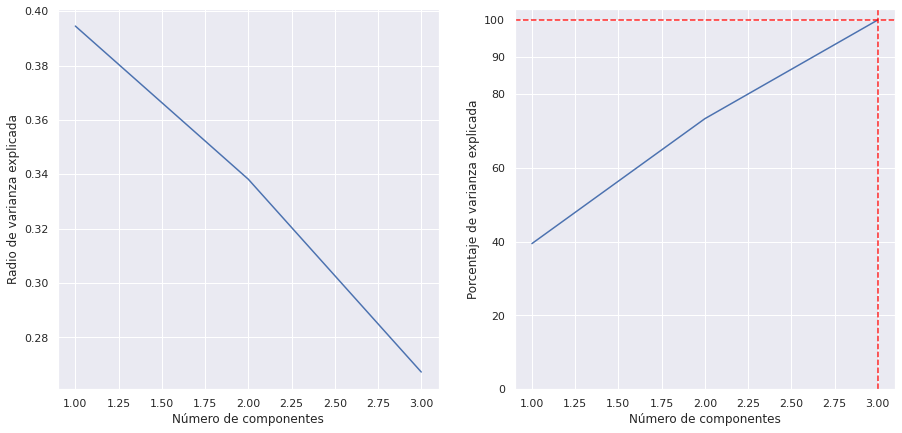

In [31]:
percent = (impca3.vars_.cumsum() / impca3.vars_.sum()) * 100

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(np.arange(1,4,1), impca3.vars_ / impca3.vars_.sum())
plt.xlabel(u'Número de componentes')
plt.ylabel(u'Radio de varianza explicada')

plt.subplot(1,2,2)
plt.plot(np.arange(1,4,1), percent)
plt.xlabel(u'Número de componentes')
plt.ylabel(u'Porcentaje de varianza explicada')
plt.axvline(x=np.argwhere(percent>=90)[0] + 1, color='red',alpha=0.85, ls='--')
plt.axhline(y=percent[np.argwhere(percent>=90)][0], color='red', alpha=0.85, ls='--')
plt.yticks([0,20,40,60,80,90,100])
plt.show()

## Texthero from Zero a Hero
`Texthero` es un paquete de Python que le permite trabajar de manera eficiente y rápida con datos de texto. Puede pensar en texthero como scikit-learn para conjuntos de datos basados ​​en texto .

Podemos encontrar una implementación fácil de este problema en la página principal de [Texthero](https://texthero.org/)

In [33]:
import texthero as hero
amzHero = amz.copy()

amzHero['tfidf'] = (hero.tfidf(amzHero['reviews.text'], max_features=400))
amzHero['pca'] = hero.pca(amzHero['tfidf'])
hero.scatterplot(
    amzHero, 
    col='pca', 
    color='primaryCategories', 
    title="PCA con TextHero"
)
plt.show()

ModuleNotFoundError: ignored

# Modelado de tópicos con descomposición de valores singulares (SVD)

En segunda instancia se utilizará el método de descomposición de valores singulares vista en clase para la separación de tópicos.

In [34]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=5, 
                        algorithm='randomized', 
                         n_iter=100, 
                         random_state=24)
svd_model.fit(X)
len(svd_model.components_)

5

Tomando la distribución de nuestros tópicos tomamos los 5 más representativos del dataset como referencia para modelar el número de tópicos.

In [35]:
#Los componentes del modelo, serán los tópicos de los documentos :D
terms = vectorizer.get_feature_names()

#Visualizamos algunas de las plabras más importantes en cada uno de los 20 tópicos
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+":")
    for t in sorted_terms:
        print(t[0])

Topic 0:
great
battery
good
price
work
tablet
love
Topic 1:
good
battery
brand
long
far
price
quality
Topic 2:
love
tablet
good
use
easy
old
kid
Topic 3:
battery
work
long
brand
use
love
amazon
Topic 4:
work
good
fine
expect
far
like
tablet


Notamos que la separación de tópicos no es muy buena pues al juzgar por las palabras en cada Topic no logramos diferenciar un tópico de otro. Esto puede ser causado por la naturaleza de las reviews en el dataset pero procederémos a utilizar un último método para modelar los tópicos.

# Usando LDA (Latent Dirichlet Allocation)

El modelado de tópicos en gran medida se puede resumir en dos puntos:

- Todo documento es una mezcla de tópicos.
- Cada tópico es una mezcla de palabras.

El LDA es un modelo matemático que sirve para estimar estos dos puntos a la vez: localizar la mezcla de palabras que se asocia con cada tópico y, a la vez, determinar la mezcla de tópicos que sirven para describir cada documento.

La implementación de un modelo LDA transforma los datos a la entrada
para establecer la siguiente representación:

- **Tópicos:** LDA devuelve una matriz de tamaño $K\times |V|$, es decir, se
definen cada tópico $k_1 :\ {i \epsilon (0,K-1)\ }$ como una composición del
aporte de cada palabra del vocabulario V en el tópico.

- **Documentos:** LDA devuelve una matriz de tamaño $D\times K$, es decir, se
define cada documento $d_i :\{i \epsilon (0,D-1)\}$ como una composición del
aporte de cada tópico del conjunto K en el documento.

Basándonos en la documentación encontrada en: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/, procedemos a implemetar el modelo LDA partiendo de nuestro vector de palabras lematizadas y tokenizadas `stem`.

In [38]:
!pip install pyldavis

  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d966f32b913fa073b189e2050248bedd104802df9f66402af66b1889131ef375
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis


In [39]:
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



Comenzaremos creando el diccionario de términos de nuestro corpus, donde a cada término único se le asigna un índice.

In [40]:
dictionary = corpora.Dictionary(stem)

Luego, convertiremos la lista de reseñas (`stem`) en una Matriz de términos del documento utilizando el diccionario preparado anteriormente.

In [41]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in stem]

Para visualizar nuestros temas en un espacio bidimensional usaremos la biblioteca **pyLDAvis**. Esta visualización es de naturaleza interactiva y muestra temas junto con las palabras más relevantes.

In [42]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different resu

In [43]:
import pyLDAvis.gensim_models

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.074623  0.206593       1        1  26.629158
4      0.098705  0.165657       2        1  23.812346
3     -0.235555  0.026199       3        1  21.164197
0     -0.122958 -0.302785       4        1  18.073498
2      0.334431 -0.095665       5        1  10.320801, topic_info=         Term         Freq        Total Category  logprob  loglift
31      great  8478.000000  8478.000000  Default  30.0000  30.0000
4322   tablet  8592.000000  8592.000000  Default  29.0000  29.0000
44       good  5339.000000  5339.000000  Default  28.0000  28.0000
4     battery  6490.000000  6490.000000  Default  27.0000  27.0000
25      price  4928.000000  4928.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
220       far   316.254969  1202.030062   Topic5  -4.8187   0.9358
24      happy   218.062819   842.994556   Topic5  -5.1904   0.9188
59    perfect   211.922559  1219.670821   Topic5  -5.2190   0.5209
123      need   218.316146  1808.102019   Topic5  -5.1893   0.1569
34     amazon   181.649833  3772.651662   Topic5  -5.3731  -0.7624

[296 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
250       3  0.999204      2
0         3  0.997879      3
268       3  0.997822      4
8907      5  0.961365     49
1067      1  0.159517      5
...     ...       ...    ...
131       5  0.271671  would
121       3  0.999736   year
2500      5  0.982565     yo
1225      3  0.998461  young
1597      3  0.996295     yr

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

Interpretación del modelado de tópicos por `pyLDAvis`:

1.Cada burbuja representa un tema.

2.La burbuja más grande corresponde a un tema más prevalente en el corpus (del que más se habla).

3.Los buenos temas son aquellos que están bien separados entre sus burbujas.

In [45]:
lda_model9 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=9, random_state=100,
                chunksize=1000, passes=50)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different resu

In [46]:
vis9 = pyLDAvis.gensim_models.prepare(lda_model9, doc_term_matrix, dictionary)
vis9

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.225825 -0.042077       1        1  21.404382
4     -0.051621 -0.151534       2        1  18.962922
5      0.233255 -0.134537       3        1  16.535432
1      0.134307 -0.143357       4        1  11.936229
7      0.032839  0.215707       5        1   7.357631
2     -0.320113 -0.072008       6        1   6.618626
8      0.007230  0.074500       7        1   6.100535
0      0.014209  0.315494       8        1   5.578330
6     -0.275932 -0.062187       9        1   5.505912, topic_info=           Term         Freq        Total Category  logprob  loglift
31        great  9034.000000  9034.000000  Default  30.0000  30.0000
4322     tablet  8415.000000  8415.000000  Default  29.0000  29.0000
25        price  4795.000000  4795.000000  Default  28.0000  28.0000
4       battery  5896.000000  5896.000000  Default  27.0000  27.0000
44         good  5237.000000  5237.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
220         far   321.148393  1131.557706   Topic9  -4.1750   1.6399
246   satisfied   115.998237   165.927588   Topic9  -5.1933   2.5414
34       amazon   271.028470  3916.571011   Topic9  -4.3446   0.2286
14         work   214.559921  3857.247765   Topic9  -4.5783   0.0102
299   excellent   137.082192   599.422482   Topic9  -5.0263   1.4240

[470 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
522       1  0.998242      1
247       1  0.997123     10
250       1  0.999492      2
2207      7  0.993588    2nd
0         1  0.998103      3
...     ...       ...    ...
121       1  0.999838   year
2500      6  0.957681     yo
1225      3  0.994861  young
613       7  0.995082  youre
1597      5  0.997411     yr

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 2, 8, 3, 9, 1, 7])

In [47]:
amz.primaryCategories.value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64


Notamos que al utilizar 5 tópicos se logra separar en burbujas completamente disjuntas. Por otra parte al usar 9 tópicos se tienen 9 burbujas distribuidas en 6 conjuntos disjuntos. 

